# Importing libraries and the datasets

In [159]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

# from wordcloud import WordCloud, STOPWORDS
import re, string, unicodedata
import nltk
#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
string.punctuation
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gdas5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gdas5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gdas5\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [160]:
# reading data
path = 'Netflix_movies_and_tv_shows_clustering.csv'

original_df = pd.read_csv(path,index_col='show_id')
df = original_df.copy()

In [161]:
#shows top 5 rows
df.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [162]:
#shows the dataframe shape in this 7787(records) and 11(attributes)
df.shape

(7787, 11)

In [163]:
# unique values in each column
df.nunique()

type               2
title           7787
director        4049
cast            6831
country          681
date_added      1565
release_year      73
rating            14
duration         216
listed_in        492
description     7769
dtype: int64

In [164]:
# Checking for duplicate records
df.duplicated().value_counts()

False    7787
Name: count, dtype: int64

In [165]:
#checking for missing values
df.isnull().sum()

type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [166]:
# Handling the missing values
df[['director','cast','country']] = df[['director','cast','country']].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.dropna(axis=0, inplace = True)

In [167]:
df.shape

(7777, 11)

In [168]:
# Top countries
df.country.value_counts()

country
United States                                                   2549
India                                                            923
Unknown                                                          506
United Kingdom                                                   396
Japan                                                            225
                                                                ... 
Russia, United States, China                                       1
Italy, Switzerland, France, Germany                                1
United States, United Kingdom, Canada                              1
United States, United Kingdom, Japan                               1
Sweden, Czech Republic, United Kingdom, Denmark, Netherlands       1
Name: count, Length: 682, dtype: int64

In [169]:
# Genre of shows
df.listed_in.value_counts()

listed_in
Documentaries                                                                      334
Stand-Up Comedy                                                                    321
Dramas, International Movies                                                       320
Comedies, Dramas, International Movies                                             243
Dramas, Independent Movies, International Movies                                   215
                                                                                  ... 
Anime Series, Crime TV Shows, TV Thrillers                                           1
Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows                         1
Crime TV Shows, International TV Shows, Reality TV                                   1
International Movies, Romantic Movies, Sci-Fi & Fantasy                              1
International TV Shows, Spanish-Language TV Shows, Stand-Up Comedy & Talk Shows      1
Name: count, Length: 491, dtype: 

- There are some movies / TV shows that were filmed in multiple countries, have multiple genres associated with it.
- To simplify the analysis, let's consider only the primary country where that respective movie / TV show was filmed.
- Also, let's consider only the primary genre of the respective movie / TV show.

In [170]:
# Choosing the primary country and primary genre to simplify the analysis
df['country'] = df['country'].apply(lambda x: x.split(',')[0])
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(',')[0])

In [171]:
# contry in which a movie was produced
df.country.value_counts()

country
United States     2877
India              956
United Kingdom     576
Unknown            506
Canada             259
                  ... 
Zimbabwe             1
Namibia              1
Soviet Union         1
Iran                 1
Somalia              1
Name: count, Length: 82, dtype: int64

In [172]:
# genre of shows
df.listed_in.value_counts()

listed_in
Dramas                          1384
Comedies                        1074
Documentaries                    751
Action & Adventure               721
International TV Shows           689
Children & Family Movies         502
Crime TV Shows                   369
Kids' TV                         357
Stand-Up Comedy                  321
Horror Movies                    244
British TV Shows                 231
Docuseries                       193
Anime Series                     147
International Movies             114
TV Comedies                      109
Reality TV                       102
Classic Movies                    77
TV Dramas                         62
Movies                            56
Thrillers                         49
TV Action & Adventure             36
Stand-Up Comedy & Talk Shows      33
Romantic TV Shows                 28
Independent Movies                20
Anime Features                    19
Classic & Cult TV                 19
Music & Musicals            

# Typecasting 'duration' from string to integer

In [173]:
# Splitting the duration column, and changing the datatype to integer
df['duration'] = df['duration'].apply(lambda x: int(x.split()[0]))

In [174]:
# Number of seasons for tv shows
df[df['type']=='TV Show'].duration.value_counts()

duration
1     1608
2      378
3      183
4       86
5       57
6       30
7       19
8       18
9        8
10       5
11       2
12       2
15       2
13       1
16       1
Name: count, dtype: int64

In [175]:
# Movie length in minutes
df[df['type']=='Movie'].duration.unique()

array([ 93,  78,  80, 123,  95, 119, 118, 143, 103,  89,  91, 149, 144,
       124,  87, 110, 128, 117, 100,  84,  99,  90, 102, 104, 105,  56,
       125,  81,  97, 106, 107, 109,  44,  75, 101,  37, 113, 114, 130,
        94, 140, 135,  82,  70, 121,  92, 164,  53,  83, 116,  86, 120,
        96, 126, 129,  77, 137, 148,  28, 122, 176,  85,  22,  68, 111,
        29, 142, 168,  21,  59,  20,  98, 108,  76,  26, 156,  30,  57,
       150, 133, 115, 154, 127, 146, 136,  88, 131,  24, 112,  74,  63,
        38,  25, 174,  60, 153, 158, 151, 162,  54,  51,  69,  64, 147,
        42,  79,  40,  45, 172,  10, 163,  55,  72,  61,  71, 160, 171,
        48, 139, 157,  15,  65, 134, 161,  62, 186,  49,  73,  58, 165,
       166, 138, 159, 141, 132,  52,  67,  34,  66, 312, 180,  47, 155,
        14, 177,  11,   9,  46, 145,   8,  12,  43,  50,  23, 185, 200,
       169,  27, 170, 196,  33, 181, 204,  32,  35, 167, 179, 193,  13,
       214,  17, 173, 192, 209, 187,  41, 182, 224, 233, 189, 15

In [176]:
# datatype of duration
df.duration.dtype

dtype('int64')

# Typecasting 'date_added' from string to datetime:

In [177]:
# Typecasting 'date_added' from string to datetime
df["date_added"] = pd.to_datetime(df["date_added"].str.strip(), format="%B %d, %Y")


In [178]:
# first and last date on which a show was added on Netflix
df.date_added.min(),df.date_added.max()

(Timestamp('2008-01-01 00:00:00'), Timestamp('2021-01-16 00:00:00'))

In [179]:
# Adding new attributes month and year of date added

df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year
df.drop('date_added', axis=1, inplace=True)

# Rating:

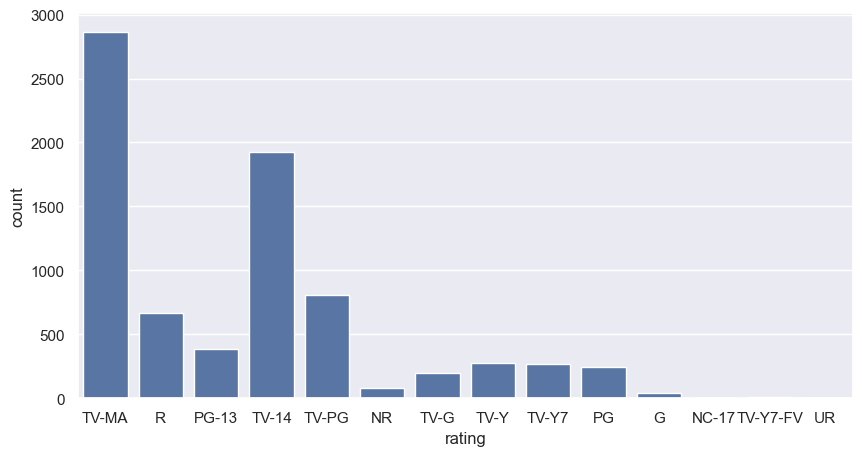

In [180]:
# Age ratings for shows in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)
plt.show()

In [181]:
# Age ratings
df.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y',
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [182]:
# Changing the values in the rating column
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
               'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

df['rating'].replace(rating_map, inplace = True)
df['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

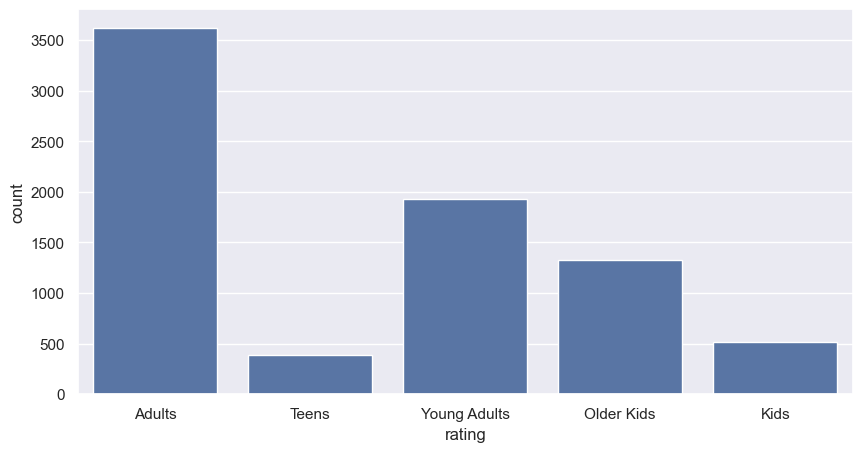

In [183]:
# Age ratings for shows in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)
plt.show()

# Exploratory Data Analysis:

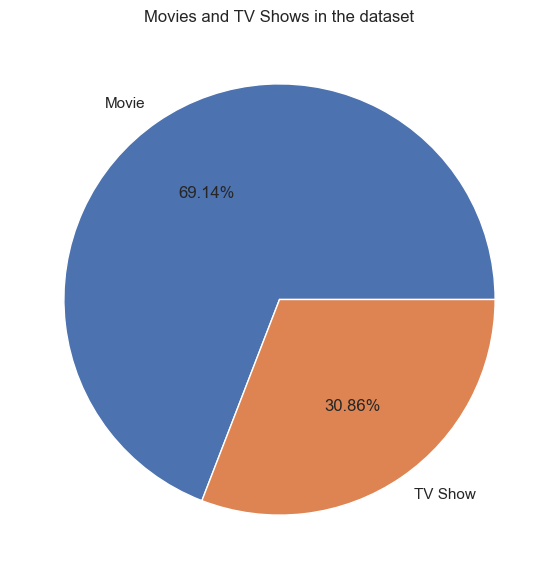

In [184]:
# Number of Movies and TV Shows in the dataset
plt.figure(figsize=(7,7))
df.type.value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.ylabel('')
plt.title('Movies and TV Shows in the dataset')
plt.show()

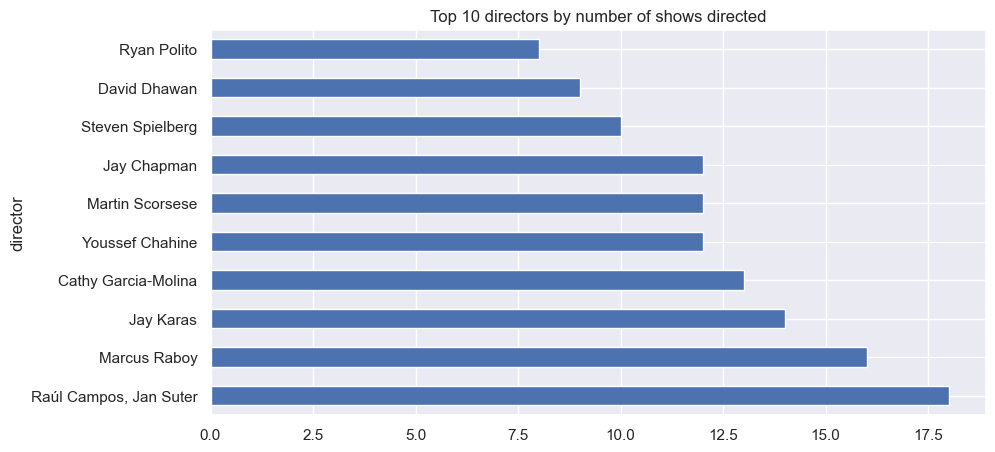

In [185]:
# Top 10 directors in the dataset
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 directors by number of shows directed')
plt.show()

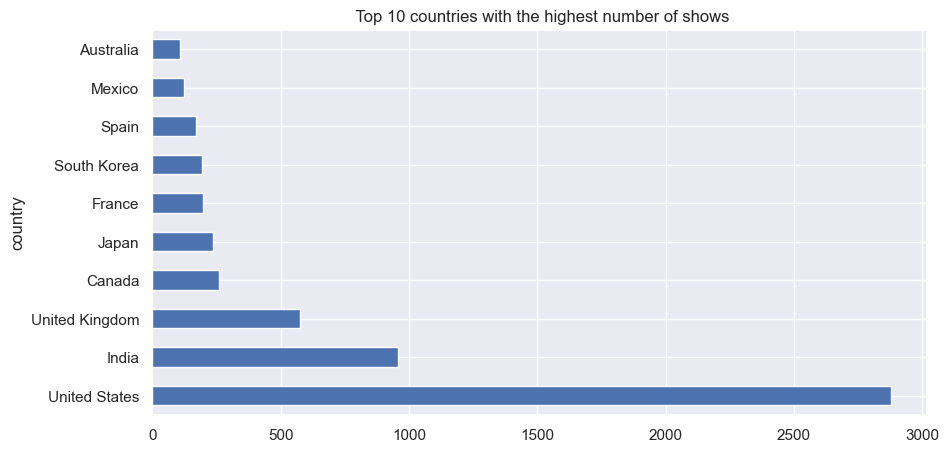

In [186]:
# Top 10 countries with the highest number movies / TV shows in the dataset
plt.figure(figsize=(10,5))
df[~(df['country']=='Unknown')].country.value_counts().nlargest(10).plot(kind='barh')
plt.title(' Top 10 countries with the highest number of shows')
plt.show()

In [187]:
# % share of movies / tv shows by top 3 countries
df.country.value_counts().nlargest(3).sum()/len(df)*100

56.69281213835669

In [188]:
# % share of movies / tv shows by top 10 countries
df.country.value_counts().nlargest(10).sum()/len(df)*100

78.32068921177832

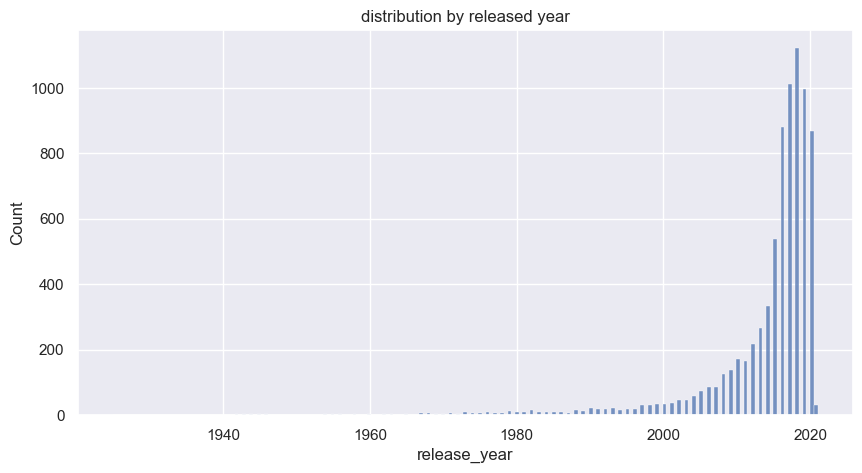

In [189]:
# Visualizing the year in which the movie / tv show was released
plt.figure(figsize=(10,5))
sns.histplot(df['release_year'])
plt.title('distribution by released year')
plt.show()

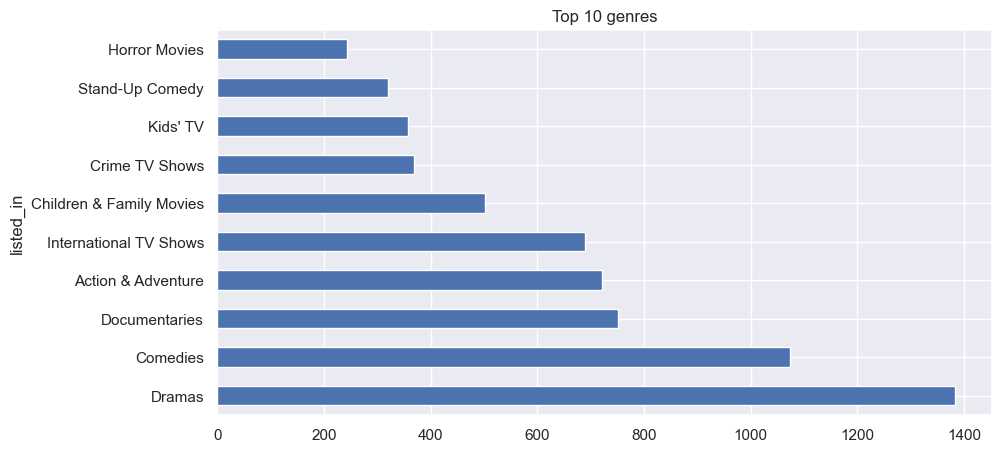

In [190]:
# Top 10 genres 
plt.figure(figsize=(10,5))
df.listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres')
plt.show()

In [191]:
# Share of top 3 genres
df.listed_in.value_counts().nlargest(3).sum()/len(df)*100

41.26269769834126

In [192]:
# Share of top 10 genres
df.listed_in.value_counts().nlargest(10).sum()/len(df)*100

82.44824482448246

# Data preprocessing:

In [193]:
# Using the original dataset for clustering since
# it does not require handling missing values
df1 = original_df.copy()

In [194]:
df1.fillna('',inplace=True)

In [195]:
# Combining all the clustering attributes into a single column

df1['clustering_attributes'] = (df1['director'] + ' ' + 
                                df1['cast'] +' ' + 
                                df1['country'] +' ' + 
                                df1['listed_in'] +' ' + 
                                df1['description'])

In [196]:
df1['clustering_attributes'][40]

'Muharrem Gülmez Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem Gülmez, Elif Nur Kerkük, Tarık Papuççuoğlu, Suzan Aksoy, Doğa Konakoğlu, Esin Eden, Deniz Özerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

In [197]:
# function to remove non-ascii characters

def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [198]:
# remove non-ascii characters
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

In [199]:
df1['clustering_attributes'][40]

'Muharrem Gulmez Erdem Yener, Ayhan Tas, Emin Olcay, Muharrem Gulmez, Elif Nur Kerkuk, Tark Papuccuoglu, Suzan Aksoy, Doga Konakoglu, Esin Eden, Deniz Ozerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

# Remove stopwords and lower case:

In [200]:
# extracting the stopwords from nltk library
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all',
       'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at',
       'be', 'because', 'been', 'before', 'being', 'below', 'between',
       'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did',
       'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don',
       "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further',
       'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
       "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers',
       'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd",
       'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it',
       "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll',
       'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn',
       "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not',
       'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'ot

In [201]:
# function to remove stop words
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [202]:
# Removing stop words
df1['clustering_attributes'] = df1['clustering_attributes'].apply(stopwords)

In [203]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener, ayhan tas, emin olcay, muharrem gulmez, elif nur kerkuk, tark papuccuoglu, suzan aksoy, doga konakoglu, esin eden, deniz ozerman turkey comedies, international movies slacker owner public bath house rallies community save big developer comes town close open new mall.'

# Remove punctuations

In [204]:
# function to remove punctuations
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [205]:
# Removing punctuation marks
df1['clustering_attributes'] = df1['clustering_attributes'].apply(remove_punctuation)

In [206]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener ayhan tas emin olcay muharrem gulmez elif nur kerkuk tark papuccuoglu suzan aksoy doga konakoglu esin eden deniz ozerman turkey comedies international movies slacker owner public bath house rallies community save big developer comes town close open new mall'

# Lemmatization:

In [207]:
# function to lemmatize the corpus
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [208]:
# Lemmatization
df1['clustering_attributes'] = lemmatize_verbs(df1['clustering_attributes'])

In [209]:
df1['clustering_attributes'][40]

'muharrem gulmez erdem yener ayhan tas emin olcay muharrem gulmez elif nur kerkuk tark papuccuoglu suzan aksoy doga konakoglu esin eden deniz ozerman turkey comedies international movies slacker owner public bath house rallies community save big developer comes town close open new mall'

# Tokenization:

In [210]:
tokenizer = TweetTokenizer()

In [211]:
df1['clustering_attributes'] = df1['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

# Vectorization:

In [212]:
# clustering tokens saved in a variable
clustering_data = df1['clustering_attributes']

In [213]:
# Tokenization
def identity_tokenizer(text):
    return text

# Using TFIDF vectorizer to vectorize the corpus 
# max features = 20000 to prevent system from crashing
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 20000)    
X = tfidf.fit_transform(clustering_data)

In [214]:
X

<7787x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 235079 stored elements in Compressed Sparse Row format>

In [215]:
# Shape of X
X.shape

(7787, 20000)

In [216]:
# data type of vector
type(X)

scipy.sparse._csr.csr_matrix

In [217]:
# convert X into array form for clustering
X = X.toarray()

# Dimensionality reduction using PCA:

In [218]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components=10, random_state=42).fit_transform(X)

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

# Clusters implementation:

## K-Means Clustering:

In [219]:
# Import
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume X is your numeric feature DataFrame (after cleaning/encoding)
print("Shape of X:", X.shape)

Shape of X: (7787, 20000)


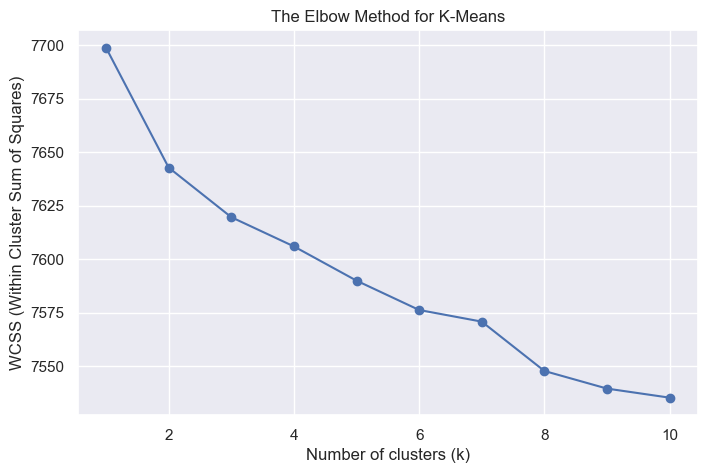

In [220]:
# 1. Elbow method to find optimal k
wcss = []
for i in range(1, 11):  # check cluster sizes from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("The Elbow Method for K-Means")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within Cluster Sum of Squares)")
plt.show()

# Content based recommender system:

In [221]:
# defining a new df for building a recommender system
recommender_df = df1.copy()

In [222]:
# Changing the index of the df from show id to show title
recommender_df['show_id'] = recommender_df.index

In [223]:
# converting tokens to string
def convert(lst):
  return ' '.join(lst)

recommender_df['clustering_attributes'] = recommender_df['clustering_attributes'].apply(lambda x: convert(x))

In [224]:
# setting title of movies/Tv shows as index
recommender_df.set_index('title',inplace=True)

In [225]:
# Count vectorizer
CV = CountVectorizer()
converted_matrix = CV.fit_transform(recommender_df['clustering_attributes'])


In [226]:
# Cosine similarity
cosine_similarity = cosine_similarity(converted_matrix)

In [227]:
cosine_similarity.shape

(7787, 7787)

In [228]:
# Developing a function to get 10 recommendations for a show
indices = pd.Series(recommender_df.index)

def recommend_10(title, cosine_sim = cosine_similarity):
  try:
    recommend_content = []   
    idx = indices[indices == title].index[0]
    series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top10 = list(series.iloc[1:11].index)
    # list with the titles of the best 10 matching movies
    for i in top10:
      recommend_content.append(list(recommender_df.index)[i])
    print("If you liked '"+title+"', you may also enjoy:\n")
    return recommend_content

  except:
    return 'Invalid Entry'

In [229]:
# Recommendations for 'A Man Called God'
recommend_10('A Man Called God')

If you liked 'A Man Called God', you may also enjoy:



['Mr. Sunshine',
 'One Spring Night',
 'Rugal',
 'The King: Eternal Monarch',
 'My Mister',
 'My Little Baby',
 'Reply 1994',
 'Extracurricular',
 'My Secret Romance',
 'Chef & My Fridge']

In [230]:
# Recommendations for 'Stranger Things'
recommend_10('Stranger Things')

If you liked 'Stranger Things', you may also enjoy:



['Beyond Stranger Things',
 'Prank Encounters',
 'The Umbrella Academy',
 'Haunted',
 'Scream',
 'Warrior Nun',
 'Nightflyers',
 'Zombie Dumb',
 'Kiss Me First',
 'The Vampire Diaries']

In [231]:
# Recommendations for 'Peaky Blinders'
recommend_10('Peaky Blinders')

If you liked 'Peaky Blinders', you may also enjoy:



['Kiss Me First',
 'Happy Valley',
 'London Spy',
 'The Frankenstein Chronicles',
 'Paranoid',
 'Get Even',
 'Giri / Haji',
 'My Hotter Half',
 'The Murder Detectives',
 'I AM A KILLER: RELEASED']

In [232]:
# Recommendations for 'Lucifer'
recommend_10('Lucifer')

If you liked 'Lucifer', you may also enjoy:



['The Good Cop',
 'Rica, Famosa, Latina',
 'Get Shorty',
 'Jack Taylor',
 'Better Call Saul',
 'Dramaworld',
 'Father Brown',
 "Marvel's Iron Fist",
 'Young Wallander',
 'No Good Nick']

In [233]:
# Recommendations for 'XXX'
recommend_10('XXX')

'Invalid Entry'

# Conclusions:

- In this project, I worked on a text clustering problem where in we had to classify/group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.
- The dataset contained about 7787 records, and 11 attributes.
- We began by dealing with the dataset's missing values and doing exploratory data analysis (EDA).
- It was found that Netflix hosts more movies than TV shows on its platform, and the total number of shows added on Netflix is growing exponentially. Also, majority of the shows were produced in the United States, and the majority of the shows on Netflix were created for adults and young adults age group.
- It was decided to cluster the data based on the attributes: director, cast, country, genre, and description. The values in these attributes were tokenized, preprocessed, and then vectorized using TFIDF vectorizer.
- Through TFIDF Vectorization, we created a total of 20000 attributes.
- We used Principal Component Analysis (PCA) to handle the curse of dimensionality. 4000 components were able to capture more than 80% of variance, and hence, the number of components were restricted to 4000.
- We first built clusters using the k-means clustering algorithm, and the optimal number of clusters came out to be 6. This was obtained through the elbow method and Silhouette score analysis.
- Then clusters were built using the Agglomerative clustering algorithm, and the optimal number of clusters came out to be 12. This was obtained after visualizing the dendrogram.
- A content based recommender system was built using the similarity matrix obtained after using cosine similarity. This recommender system will make 10 recommendations to the user based on the type of show they watched.
